In [1]:
#import libraries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#for feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
#split in train-test set
from sklearn.model_selection import train_test_split as split

#model evalutaion metrics
from sklearn import metrics

#for hyperparameters tuning
from sklearn.model_selection import RandomizedSearchCV

#for constructing distributions:
from scipy.stats import uniform
from scipy.stats import loguniform

import math

                                                             3rd Machine Learning Project - start2impact - Davide Miglietta

                                                                                                        NOTEBOOK 3: SVR                                                           

# Student Alcohol Consumption

### SVR:

In this notebook the prediction is done using a Support Vector Regressor (SVR). Treating different ML algorithms in different notebooks, let perform a more detailed analysis and optimization. Each model usually reach best performances in different conditions: for instance, Random Forest generally deal good with high number of features and doesn't need features scaling or transformations. For this reason, Random Forest and Support Vector Regression have been studied in different notebooks and after that, compared.

## Table of contents:
1. [Data Manipulation](#1)
    - [Features and Target](#1.1)
    - [Train/Test Set Split](#1.2)


2. [Functions Definition for ML Analysis](#2)


3. [Random Forest](#3)


4. [Features Importance Evaluation](#4)
    - [Random Forest with Features Subset](#4.1)


5. [Models Comparation](#5)
    - [Results Scatterplot](#5.1)
    - [Residuals Distributions](#5.2)
    - [Metrics Comparation](#5.3)



## 1

## Data Manipulation

In [2]:
#portuguese dataset import
df = pd.read_csv('student-por.csv')
print(df.shape)
df.head(2)

(649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11


In [3]:
#splitting categorical variables to transform in numbers
categorical = df.select_dtypes(include=['object'])
cat_columns = categorical.columns.tolist()
print(cat_columns)

#one-hot encoding
categorical = pd.get_dummies(categorical)
categorical.head(2)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1,0,1,0,0,1,1,0,1,0,...,1,0,0,1,0,1,1,0,1,0
1,1,0,1,0,0,1,1,0,0,1,...,1,0,1,0,0,1,0,1,1,0


In [4]:
#from df drop the categorcal columns
df=df.drop(cat_columns, axis=1)
#and substitute with the one-hot encoded dataframe
df = pd.concat([df, categorical], axis = 1)
print(df.shape)

'''Finally, grades G1 and G2 have been removed from the dataset.
That's beacuse they are strictly correlated with the final grade G3 that we want to predict:
Basically, G3 is a "consequence" of G1 and G2. 

We suppose that in a real case, either or we don't have G1 and G2,
or if we have, we can simply use those two grades for a very simple linear regression.'''

df=df.drop(['G1', 'G2'], axis=1)
print(df.shape)

df.head(2)

(649, 59)
(649, 57)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0


### 1.1

### Features and Target

In [5]:
#as said, the target y is the fianl grade G3
y = df.pop('G3')

print(y)

#a subset of features is copied
X = df.copy()
X.head(2)

0      11
1      11
2      12
3      14
4      13
       ..
644    10
645    16
646     9
647    10
648    11
Name: G3, Length: 649, dtype: int64


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0


### 1.2

### Train/Test Set Split

In [6]:
#setting same conditions for replicabilty: test_size =.2, random_state=0

X_train, X_test, y_train, y_test = split(X, y, test_size =.2, random_state=0) 

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print('****************')
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(649, 56)
(519, 56)
(130, 56)
****************
(649,)
(519,)
(130,)


In [7]:
#dataset scaling
scaler = MinMaxScaler()

#calculating mean and variance of every feature on the train set, then scaling it
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns=X.columns

#the calculated parameters are used to transform the test set
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns=X.columns
X_test.head(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,0.142857,0.5,0.25,0.333333,0.333333,0.0,0.75,0.25,0.25,0.00,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.285714,0.0,0.50,0.333333,0.666667,0.0,0.50,0.50,0.50,0.25,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [8]:
X_train.head(2)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,0.142857,0.75,0.50,0.0,0.0,0.000000,1.0,0.75,0.50,0.00,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.285714,0.25,0.25,0.0,0.0,0.333333,1.0,0.75,0.75,0.25,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


## 2

## Functions Definition for ML Analysis

Functions of notebook 2 are re-used.

In [9]:
def random_search(model, parameters, k, scoring, N):
       
    rs = RandomizedSearchCV(model, parameters, cv = k, scoring = scoring, n_iter = N, verbose = 50, n_jobs = -1) 
    rs = rs.fit(X_train,y_train)
    
    #'model_dict' is a dictionary containing all results of RandomizedSearchCV() for an easier later consultation
    model_dict = {}
    model_dict['best_score'] = rs.best_score_
    model_dict['best_params'] = rs.best_params_
    
    model_dict['params'] = rs.cv_results_['params']
    model_dict['means'] = rs.cv_results_['mean_test_score']
    model_dict['stds'] = rs.cv_results_['std_test_score']
        
    model_dict['MAE_train'] = metrics.mean_absolute_error(y_train, rs.predict(X_train))
    model_dict['MSE_train'] = metrics.mean_squared_error(y_train, rs.predict(X_train))
    model_dict['RMSE_train'] = np.sqrt(metrics.mean_squared_error(y_train, rs.predict(X_train)))
    model_dict['r2_train'] = np.sqrt(metrics.r2_score(y_train, rs.predict(X_train)))
    
    model_dict['MAE_test'] = metrics.mean_absolute_error(y_test, rs.predict(X_test))
    model_dict['MSE_test'] = metrics.mean_squared_error(y_test, rs.predict(X_test))
    model_dict['RMSE_test'] = np.sqrt(metrics.mean_squared_error(y_test, rs.predict(X_test)))
    model_dict['r2_test'] = np.sqrt(metrics.r2_score(y_test, rs.predict(X_test)))
        
    best_model = rs.best_estimator_
    
    return best_model, model_dict

In [10]:
def see_randomsearch_results(x, model_dict, regr_model):
    
    print('Best Model:', regr_model)
    print('\nBest score ({}): {:.2f}'.format(scoring, model_dict['best_score']))
    
    #to organize in descending order the results of the RandomizedSearchCV()
    #and organize consequently the corresponding standard deviations and list of parameters
    
    means = list(model_dict['means'])
    stds = list(model_dict['stds'])
    params = list(model_dict['params'])
     
    sorted_lists = sorted(zip(means, stds, params), reverse = True, key = lambda l:l[0])
    tuples = zip(*sorted_lists)
    sorted_means, sorted_stds, sorted_params = [ list(tuple) for tuple in  tuples]
    
    plt.figure(figsize=(20, 4))
    
    #plot a point corresponding to the score and a bar corresponding to the std dev for each group of parameters
    plt.errorbar(np.arange(x), sorted_means[:x], yerr=sorted_stds[:x], fmt='o', ms=15,
                 ecolor='green', capsize=15, capthick=3)
    plt.xticks(np.arange(x))
    
    plt.show()

    print('Chart Legend:\n')
    
    for i in np.arange(x):
        print('{} --> Hyperparameters: {}'.format(i, sorted_params[i]))

### Functions parameters

In [11]:
print(metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [12]:
k = 5 #k-folds for cross validation

'''As discriminating metric it has ben chosed the mean squared error, since it has been noticed that,
the model has worst performances for high grades. In this way we try to minimize big errors.'''

scoring = 'neg_mean_squared_error'

N = 200 #number of iterations (combination of hyperparameters)


## 3

## SVR

Hyperparameters meaning has been explained in notebook 2.

In [13]:
from sklearn.svm import SVR

regressor = SVR()

C_range = loguniform(1e-3, 1e3)
gamma_range = loguniform(1e-4, 1e3)
degree_range = np.arange(2,5)
epsilon_range = loguniform(1e-3, 1e4)

parameters = [
                {'kernel' : ['linear'], 'C' : C_range, 'epsilon': epsilon_range},
                {'kernel' : ['rbf'], 'C' : C_range, 'gamma' : gamma_range, 'epsilon': epsilon_range},
                {'kernel' : ['poly'], 'C' : C_range, 'degree' : degree_range, 'epsilon': epsilon_range}
                
             ]


SVR_model, SVR_dict = random_search(regressor, parameters, k, scoring, N)

SVR_predictions = SVR_model.predict(X_test)

print('\nDone!')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 519 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 523 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 525 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 526 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 527 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed:   27.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Batch computation too slow (3.0672s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elap

[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 951 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 954 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 958 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 966 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 970 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 972 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 974 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.3min
[Paralle

Best Model: SVR(C=0.7353869964829043, degree=2, epsilon=0.07117923935091298, kernel='poly')

Best score (neg_mean_squared_error): -8.15


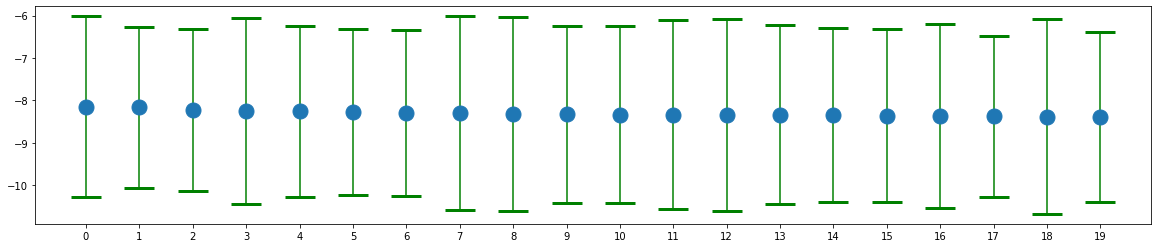

Chart Legend:

0 --> Hyperparameters: {'C': 0.7353869964829043, 'degree': 2, 'epsilon': 0.07117923935091298, 'kernel': 'poly'}
1 --> Hyperparameters: {'C': 58.615303126213995, 'epsilon': 1.137097425799617, 'kernel': 'linear'}
2 --> Hyperparameters: {'C': 1.1777918340815086, 'epsilon': 0.7582464866806493, 'kernel': 'linear'}
3 --> Hyperparameters: {'C': 0.5615627670879073, 'degree': 3, 'epsilon': 0.003695868641227853, 'kernel': 'poly'}
4 --> Hyperparameters: {'C': 361.45098836533964, 'epsilon': 0.16272719747733175, 'gamma': 0.00254510507846948, 'kernel': 'rbf'}
5 --> Hyperparameters: {'C': 0.5763361980665511, 'epsilon': 0.7263877413303382, 'kernel': 'linear'}
6 --> Hyperparameters: {'C': 0.2981687730325398, 'epsilon': 0.5638873994606507, 'kernel': 'linear'}
7 --> Hyperparameters: {'C': 0.19769769241349455, 'degree': 4, 'epsilon': 0.08602210231096723, 'kernel': 'poly'}
8 --> Hyperparameters: {'C': 0.2897535306188926, 'degree': 4, 'epsilon': 0.02116284990925771, 'kernel': 'poly'}
9 --> Hy

In [14]:
see_randomsearch_results(20, SVR_dict, SVR_model)

## 4

## Features Importance Evaluation

As a first attempt all features have been used. After that it makes sense try to reduce the number of features. To do so, it is appropriate try to understand the importance that each feature has on the prediction

**Permutation Importance**, from sklearn, allows to understand -for the given model- the importance of the features in the prediction. *It can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.* [https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance]

Note that this method is strictly related with the model: it reveals the features importance for that specific model and not absolutley.

In [15]:
'''Randomly shuffled significa proprio... randomly shuffled? :)
Cioè operativamente prende una feature e la mischia a caso? 
significa che per la feature1 prende il valore corrispondente allo studente1 e lo assegna allo studente3,
quella dello studente3 allo studente 10 ecc?mantenendo il resto del dataset inalterato. 

Il che significa che, dopo lo shuffle, se non c'è una caduta nella prestazione 
allora quella feature non è molto importante.

Ho capito correttamente?

Se usare questo metodo o altri (per esempio features importance per RF, o PCA o variance treshold) è come al solito
provare empiricamente o ci sono delle linee guida generali?
'''

"Randomly shuffled significa proprio... randomly shuffled? :)\nCioè operativamente prende una feature e la mischia a caso? \nsignifica che per la feature1 prende il valore corrispondente allo studente1 e lo assegna allo studente3,\nquella dello studente3 allo studente 10 ecc?mantenendo il resto del dataset inalterato. \n\nIl che significa che, dopo lo shuffle, se non c'è una caduta nella prestazione \nallora quella feature non è molto importante.\n\nHo capito correttamente?\n\nSe usare questo metodo o altri (per esempio features importance per RF, o PCA o variance treshold) è come al solito\nprovare empiricamente o ci sono delle linee guida generali?\n"

In [16]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(SVR_model, X_train, y_train, 
                                         scoring=scoring, n_repeats=10, n_jobs=-1, random_state=0)



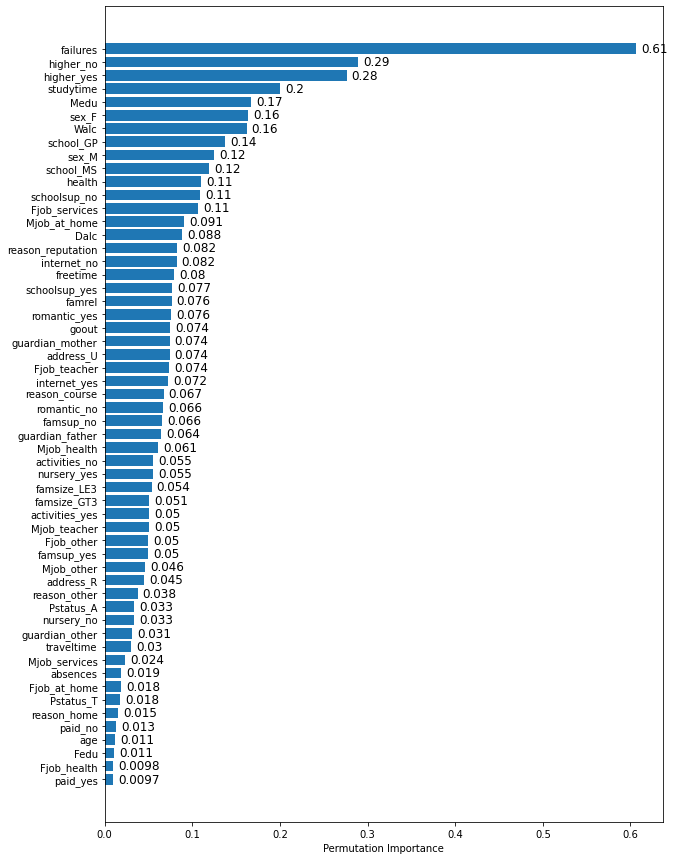

In [17]:
sorted_idx = perm_importance.importances_mean.argsort()
imp = perm_importance.importances_mean[sorted_idx]


fig, ax = plt.subplots(figsize=(10,15))
hbar=plt.barh(X.columns[sorted_idx], imp)
plt.bar_label(hbar, size=12, padding=5, labels=['{:.2}'.format(a) for a in imp])
plt.xlabel('Permutation Importance')

plt.show()

The first 15 more important features are selected.

In [18]:
columns=X.columns[sorted_idx][-15:]
print(columns)

X_train = X_train[columns]
X_test = X_test[columns]

X_train.head(2)

Index(['Dalc', 'Mjob_at_home', 'Fjob_services', 'schoolsup_no', 'health',
       'school_MS', 'sex_M', 'school_GP', 'Walc', 'sex_F', 'Medu', 'studytime',
       'higher_yes', 'higher_no', 'failures'],
      dtype='object')


,Dalc,Mjob_at_home,Fjob_services,schoolsup_no,health,school_MS,sex_M,school_GP,Walc,sex_F,Medu,studytime,higher_yes,higher_no,failures
0,0.00,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.00,0.0,0.75,0.0,1.0,0.0,0.000000
1,0.25,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.25,1.0,0.25,0.0,0.0,1.0,0.333333


### 4.1

### SVR with Features Subset

After defining the subset that seems to be more predictive, we run again the random search function, but in this case not to find new parameters. In fact, we are using the parameters of the 'best model' found before. This because:

* having done the permutation features selection: the selected features are important for the specific model
* it's practical to use the defined function (with only one iteration, being basically a cross validation) in order to have results in the same structures than the first prevision This is useful for the comparation.

In [19]:
'''First we get the parameters and create a new dictionary, called model_parameters.
We keep only the ones that are of interest, with attention that the values are lists (for the function to work).'''

model_parameters = SVR_model.get_params()
print(model_parameters.keys())

for p in list(model_parameters.keys()):
    if p not in ['C', 'degree', 'epsilon', 'gamma', 'kernel']:
        model_parameters.pop(p)
    else:
        value = model_parameters[p]
        model_parameters[p] = []
        model_parameters[p].append(value)


model_parameters

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])


{'C': [0.7353869964829043],
 'degree': [2],
 'epsilon': [0.07117923935091298],
 'gamma': ['scale'],
 'kernel': ['poly']}

In [20]:
#applying the function with one set of parameters
regressor = SVR()

parameters = model_parameters

SVR_model_subset, SVR_dict_subset = random_search(regressor, parameters, k, scoring, 1) #one iteration

SVR_predictions_subset = SVR_model_subset.predict(X_test)

print('\nDone!')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0341s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished

Done!


Best Model: SVR(C=0.7353869964829043, degree=2, epsilon=0.07117923935091298, kernel='poly')

Best score (neg_mean_squared_error): -7.82


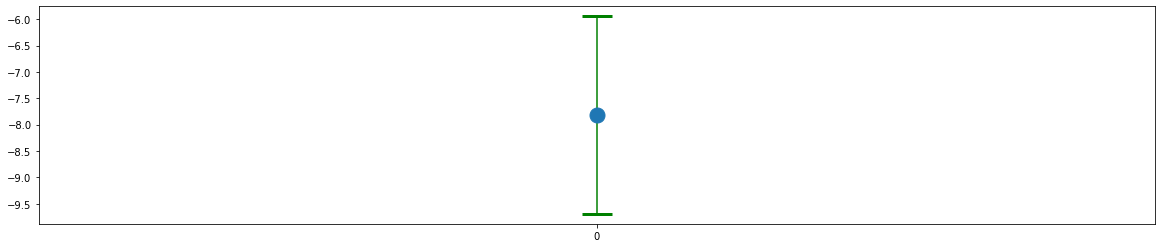

Chart Legend:

0 --> Hyperparameters: {'kernel': 'poly', 'gamma': 'scale', 'epsilon': 0.07117923935091298, 'degree': 2, 'C': 0.7353869964829043}


In [21]:
see_randomsearch_results(1, SVR_dict_subset, SVR_model_subset)

Now we are ready to  compare results obtained using all features and ones obtained with just a subset.

### 5

### Models Comparation

In this section the results obtained will be compared in order to find the model with the best performance.

In [22]:
#the following lists are creating for an easier iteration of the following part

#those three lists should be of the same length and contains model information in the same order
#then all the rest is 'automatically' arranged
models = ['SVR', 'SVR Subset']
dicts = [SVR_dict, SVR_dict_subset]
regr_predictions = [SVR_predictions, SVR_predictions_subset]

name_metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'r2' ]
train_metrics = ['MAE_train', 'MSE_train', 'RMSE_train', 'r2_train']
test_metrics = ['MAE_test', 'MSE_test', 'RMSE_test', 'r2_test']

### 5.1

### Results scatterplots

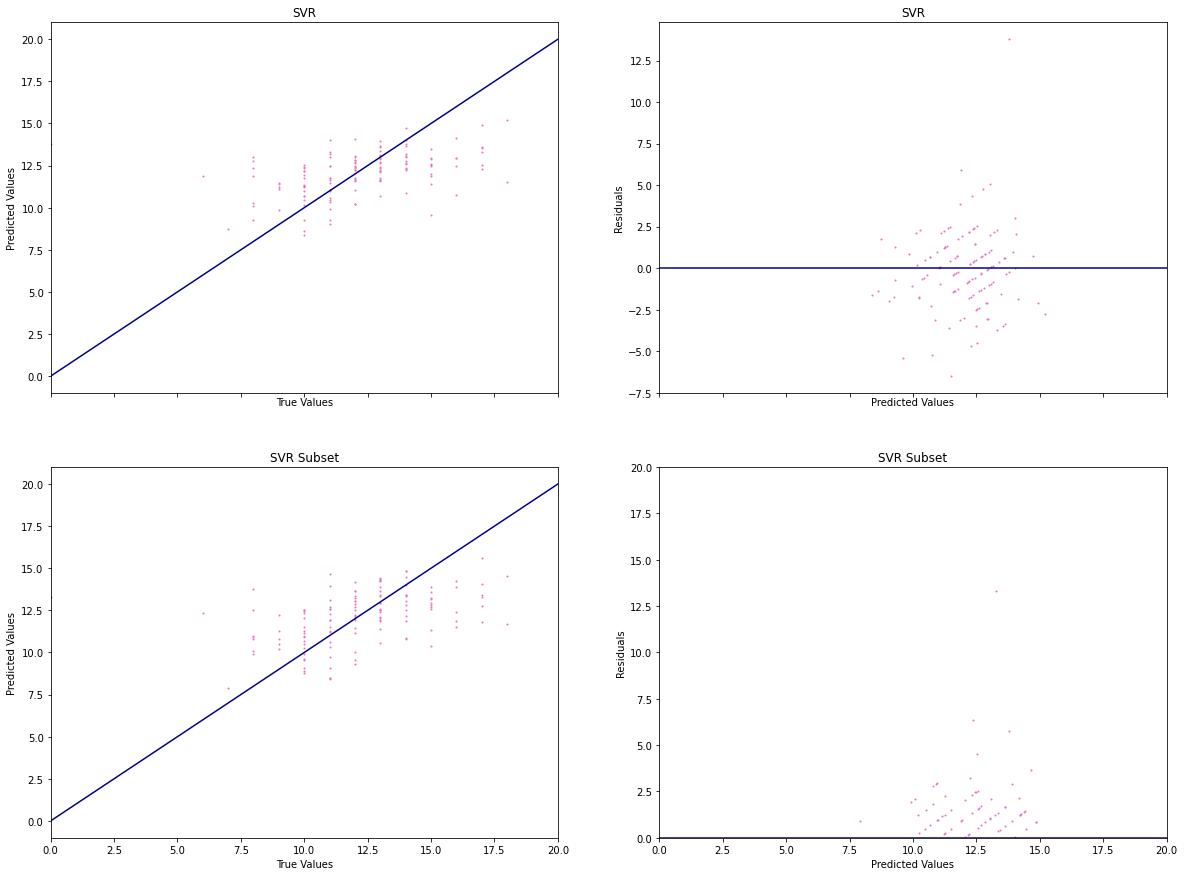

In [23]:
i = 0

fig, axes = plt.subplots(nrows = len(regr_predictions), ncols = 2, sharex = True, figsize = (20,15))

for pred, ax in zip(regr_predictions, axes):
    
    ax1 = ax[0]
    ax1.scatter(y_test, regr_predictions[i], s=1, c = 'tab:pink') #color is fixed: pink as in the secod notebook for RF
    ax1.plot([0, 20], [0, 20], color='darkblue')
    
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(models[i])
    
    residuals = pred - y_test
    
    ax2 = ax[1]
    ax2.scatter(pred, residuals, s=1, c = 'tab:pink')
    ax2.axhline(color='darkblue')

    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(models[i])
    i = i + 1

plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

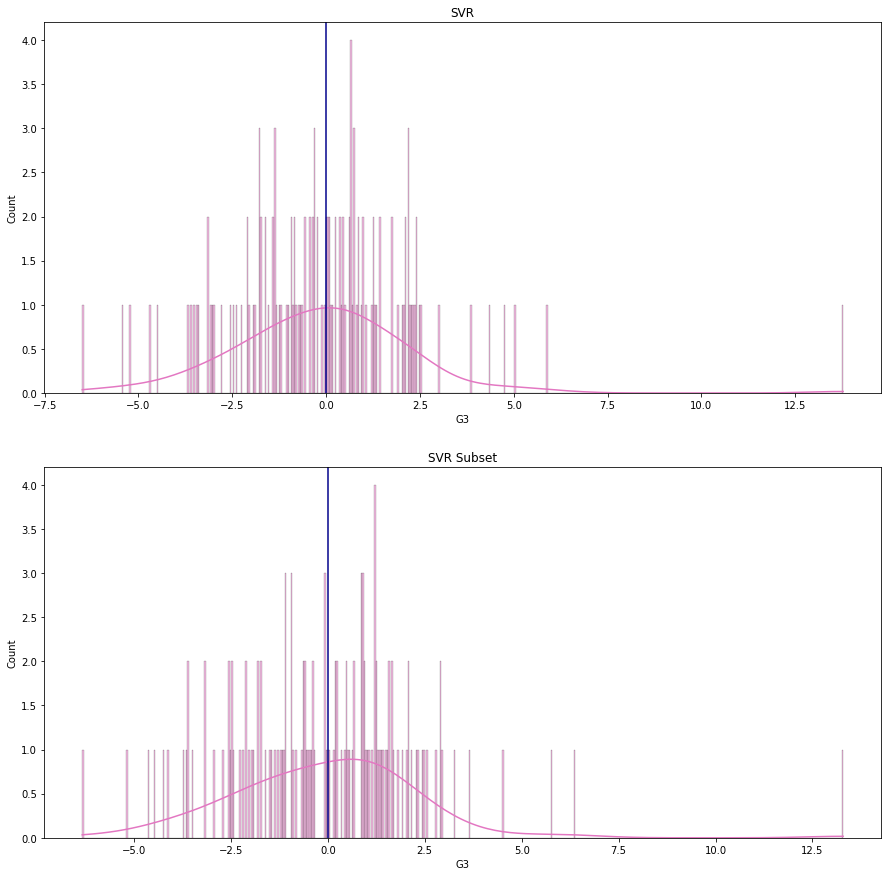

In [24]:
i = 0

fig, axes = plt.subplots(nrows = len(regr_predictions), ncols = 1, figsize = (15,15))

for pred, ax in zip(regr_predictions, axes):
    residuals = pred - y_test
    sns.histplot(residuals, bins=500, kde = True, ax=ax, color='tab:pink')
    ax.axvline(color = 'darkblue')
    ax.set_title(models[i])
    i = i + 1

### 4.3

### Metrics Comparation

- the circle marker refers to the Train Set
- the star marker refers to the Test Set

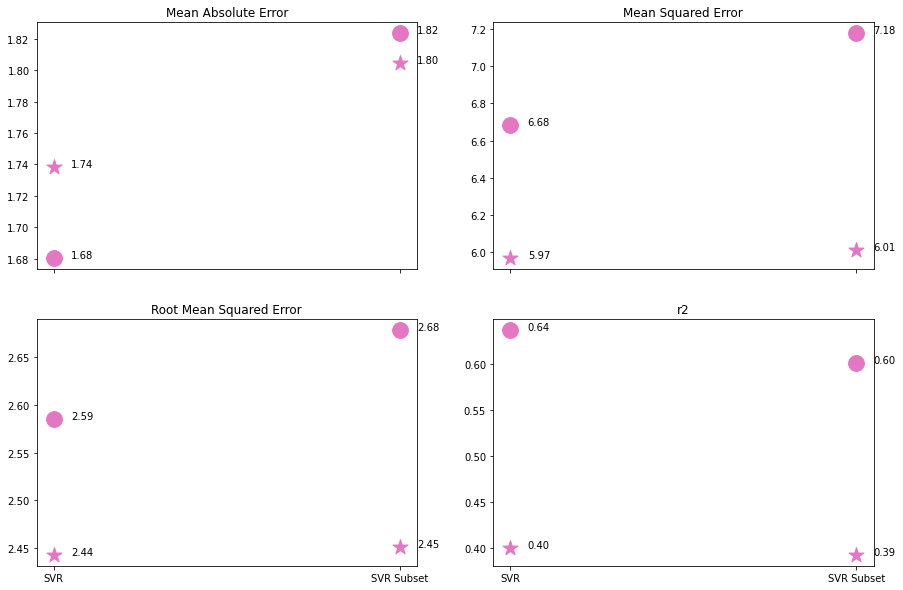

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex =True, figsize = (15,10))

for ax, train_metric, test_metric, metric in zip(axes.flat, train_metrics, test_metrics, name_metrics):
    
    for d, i, model in zip(dicts, range(len(dicts)), models):
        
        #print('Model: {} - Metric: {} - Value: {:.2f}\n'.format(model, metric, d[train_metric]))
        
        ax.scatter(x = i, y = d[train_metric], marker = 'o', color = 'tab:pink', s = 250)
        ax.annotate(str('{:.2f}'.format(d[train_metric])),( i + 0.05, d[train_metric]))
        
        ax.scatter(x = i, y = d[test_metric], marker = '*', color = 'tab:pink', s = 250)
        ax.annotate(str('{:.2f}'.format(d[test_metric])),( i + 0.05, d[test_metric]))
        
        ax.set_title(metric)
        
plt.xticks(range(len(dicts)),models)

plt.show()


No sensible improvement is visible. The same procedure will be applied in notebook 4 with Random Forest.